# Temporalis demonstration notebook

In this notebook we demonstrates the use of the [Temporalis](http://temporalis.readthedocs.io/en/latest/) software. You should also know about the [Brightway2 LCA framework](http://brightwaylca.org/) on which Temporalis is based

In [2]:
import bw2temporalis
print("Temporialis version:", bw2temporalis.__version__)
assert bw2temporalis.__version__ >= (1, 0), "Temporalis needs to be upgraded!"

Temporialis version: (1, 0)


We start with some general Brightway2 setup like setting the project, registering the default biosphere database and ecoinvent.

In [3]:
from brightway2 import *
from bw2temporalis import *
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

In [4]:
if "temporalis_demo" not in list(projects):
    projects.create_project("temporalis_demo")
projects.set_current("temporalis_demo")

In [5]:
if "biosphere3" not in databases:
    create_default_biosphere3()

In [6]:
ei = SingleOutputEcospold2Importer(
    "/media/giuseppec/25F62A4E5FEED162/work/LCA_db-software/ecoinvent/current_Version_3.2_cutoff_ecoSpold02/datasets", #CHANGE WITH THE FILEPATH OF YOUR ECOINVENT 3.x CUTOFF OR ECOINVENT 2.2
    "ecoinvent 3.2 cutoff"
)
ei.apply_strategies()
ei.write_database()

to make the calculation faster we set ecoinvent to static as explained in the [documentation](http://temporalis.readthedocs.io/en/latest/gotcha.html)

In [7]:
databases['ecoinvent 3.2 cutoff']['static'] = True
databases.flush()

## Create the temporal inventory database with ecoinvent included
Below create our temporal database which reflect the [following flow diagram](https://bitbucket.org/cardosan/brightway2-temporalis/src/tip/docs/example.svg?at=default&fileviewer=file-view-default). We model the (fictitious) cradle-to-grave life cycle of a wood product use. Other than including several temporal informations we use the ecoinvent activity for forestry which includes impact of forestry interventions as well as the biogenic carbon sequestration from forest.

![](example.svg)

In [8]:
METHANE = ('biosphere3', '0795345f-c7ae-410c-ad25-1845784c75f5')  # Methane, fossil, air, kg
CO2 = ('biosphere3', 'f9749677-9c9f-4678-ab55-c607dfdc2cb9')      # Carbon dioxide, fossil, kg

In [9]:
data = {
    ('example', 'FU'): { #our functional unit i.e. the use of 1 m3 of wood for 5 years
        'exchanges': [
            {
                'amount': 5,
                'input': ('example', 'Wood Use'),
                'temporal distribution': TemporalDistribution(np.array([ 0,  1,  2,  3,  4],dtype='timedelta64[Y]') ,np.array([1.0, 1.0, 1.0, 1.0, 1.0])),
                'type': 'technosphere'
            },
        ],
        'name': 'FU',
        'type': 'process'
    },
    ('example', 'Wood Use'): {
        'exchanges': [
            {
                'amount': 0.8,
                'input': ('example', 'Incineration'),
                'type': 'technosphere'
            },
            {
                'amount': 0.2,
                'input': ('example', 'Landfilling'),
                'type': 'technosphere'
            },
            {
                'amount': 1,
                'input': ('example', 'Sawmilling'),
                'type': 'technosphere'
            },
        ],
        'name': 'Wood Use',
        'type': 'process'
    },
    ('example', 'Landfilling'): {
        'exchanges': [
            {
                'amount': 10,
                'input': METHANE,
                'temporal distribution': TemporalDistribution(np.array([10,20,40,60],dtype='timedelta64[Y]') ,np.array([2.5]*4)), 
                'type': 'biosphere'
            },
        ],
        'name': 'Landfilling',
        'type': 'process'
    },
    ('example', 'Incineration'): {
        'exchanges': [
            {
                'amount': 1,
                'input': ('example', 'Energy production'),
                'type': 'substitution'
            },
            {
                'amount': 30,
                'input': CO2,
                'type': 'biosphere'
            },
        ],
        'name': 'Incineration',
        'type': 'process'
    },
    ('example', 'Energy production'): {
        'exchanges': [
            {
                'amount': 4,
                'input': CO2,
                'type': 'biosphere'
            },

        ],
        'name': 'Energy production',
        'type': 'process'
    },
    ('example', 'Sawmilling'): {
        'exchanges': [
            {
                'amount': 1,
                'input': ('example', 'Transport'),
                'temporal distribution': TemporalDistribution(np.array([1],dtype='timedelta64[Y]') ,np.array([1.0])),
                'type': 'technosphere'
            },
        ],
        'name': 'Sawmilling',
        'type': 'process'
    },
    ('example', 'Transport'): {
        'exchanges': [
            {
                'amount': 1.2,
                #below search `softwood, standing, under bark, in forest` if you are using ecoinvent 2.2
                'input': Database('ecoinvent 3.2 cutoff').search('"softwood forestry, mixed species, sustainable forest management"')[0],
                'temporal distribution': TemporalDistribution(np.array([24],dtype='timedelta64[M]') ,np.array([1.2])),
                'type': 'technosphere'
            },
            {
                'amount': 5,
                'input': CO2,
                'type': 'biosphere'
            },
        ],
        'name': 'Transport',
        'type': 'process'
    },

}

db = Database("example")
db.write(data)

Writing activities to SQLite3 database:
0%   100%
[#######] | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 04/15/2018 09:17:19
  Finished: 04/15/2018 09:17:19
  Total time elapsed: 00:00:00
  CPU %: 262.50
  Memory %: 2.15


## Dynamic LCI
Ok now we can solve our dynamic LCI to obtain a timeline containing biosphere flows and processes responsible for these emissions.  Our (dynamic) functional unit is represented by the use of 1 m3 of wood for 5 years starting from 2015 (the `t0`).

In [11]:
dynamic_lca = DynamicLCA(
    demand={('example', 'FU'): 1}, 
    worst_case_method=('RadiativeForcing', 'worst case'), 
    t0=np.datetime64('2015-01-01')
)
timeline = dynamic_lca.calculate()

Our `timeline` object is a `namedtuple` s 

In [25]:
timeline.raw[:5]

[data_point(dt=datetime.datetime(2011, 1, 1, 5, 49, 12), flow=('biosphere3', 'f9749677-9c9f-4678-ab55-c607dfdc2cb9'), ds=('example', 'Transport'), amount=5.0),
 data_point(dt=datetime.datetime(2012, 1, 1, 11, 38, 24), flow=('biosphere3', 'f9749677-9c9f-4678-ab55-c607dfdc2cb9'), ds=('example', 'Transport'), amount=5.0),
 data_point(dt=datetime.datetime(2012, 12, 31, 17, 27, 36), flow=('biosphere3', 'f9749677-9c9f-4678-ab55-c607dfdc2cb9'), ds=('example', 'Transport'), amount=5.0),
 data_point(dt=datetime.datetime(2013, 12, 31, 23, 16, 48), flow=('biosphere3', 'f9749677-9c9f-4678-ab55-c607dfdc2cb9'), ds=('example', 'Transport'), amount=5.0),
 data_point(dt=datetime.datetime(2015, 1, 1, 5, 6), flow=('biosphere3', 'f9749677-9c9f-4678-ab55-c607dfdc2cb9'), ds=('example', 'Transport'), amount=5.0)]

we can look at the biosphere flows emitted

In [12]:
timeline.flows()

{('biosphere3', '0795345f-c7ae-410c-ad25-1845784c75f5'),
 ('biosphere3', '16eeda8a-1ea2-408e-ab37-2648495058dd'),
 ('biosphere3', '20185046-64bb-4c09-a8e7-e8a9e144ca98'),
 ('biosphere3', '349b29d1-3e58-4c66-98b9-9d1a076efd2e'),
 ('biosphere3', '35d1dff5-b535-4628-9826-4a8fce08a1f2'),
 ('biosphere3', '473826ae-125a-4b02-8c8e-c84322491d80'),
 ('biosphere3', '57bdb443-d4a6-423d-8024-959b8261d02e'),
 ('biosphere3', '5f7aad3d-566c-4d0d-ad59-e765f971aa0f'),
 ('biosphere3', '6b1b495b-70ee-4be6-b1c2-3031aa4d6add'),
 ('biosphere3', '6dc1b46f-ee89-4495-95c4-b8a637bcd6cb'),
 ('biosphere3', '70ef743b-3ed5-4a6d-b192-fb6d62378555'),
 ('biosphere3', '78eb1859-abd9-44c6-9ce3-f3b5b33d619c'),
 ('biosphere3', '81305cda-63f1-4c1a-99c6-2c2568550ec4'),
 ('biosphere3', '856c9aa2-c20c-49a8-9417-c71bdb5f17b0'),
 ('biosphere3', '9541a975-800f-4fed-9edf-28f6e411a015'),
 ('biosphere3', 'aa7cac3a-3625-41d4-bc54-33e2cf11ec46'),
 ('biosphere3', 'afd6d670-bbb0-4625-9730-04088a5b035e'),
 ('biosphere3', 'b53d3744-3629-

and the processes

In [13]:
timeline.processes()

{('ecoinvent 3.2 cutoff', 'd63bbaea0bba23c6b9f02b946d1e7bf8'),
 ('example', 'Energy production'),
 ('example', 'Incineration'),
 ('example', 'Landfilling'),
 ('example', 'Transport')}

we can also look at the total environmental intervention for one biosphere flow

In [14]:
timeline.total_amount_for_flow(METHANE)

10.002055753190366

and the total environmental intervention for a specific biosphere flow due to an activity

In [15]:
timeline.total_flow_for_activity(METHANE,('example', 'Landfilling'))

10.0

## Dynamic LCIA

Ok now we can calculate our LCIA impact using a static characterization factor (CF). In this case we as static CF the IPCC GWP included in ecoinvent as example

/home/giuseppec/miniconda3/envs/bw2/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


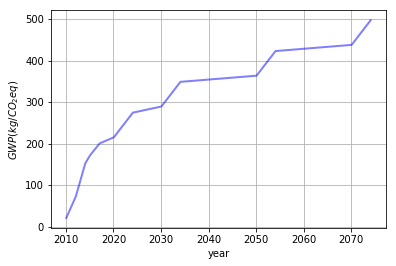

In [16]:
xs, ys  = timeline.characterize_static(('IPCC 2013', 'climate change', 'GWP 100a'))
plt.plot(xs, ys, 'b-', lw=2, alpha=0.5)

# Format graph
plt.xlabel("year")
plt.ylabel("$GWP (kg/CO_{2}eq)$")
plt.grid(True)

plt.legend(loc="lower left")
# plt.axhline(y=0, xmin=0, xmax=1, hold=None, color='black')

## Create dynamic LCIA methods

Temporalis has already built-in the method to create some IPCC climate metrics (from 2013 assessment report) like  Radiative Forcing and Global Temperature potential. 
We can install them with the function `create_climate_methods` which will also calculate and create their [worst-case](http://temporalis.readthedocs.io/en/latest/traversal.html#worst-case-approach) characterization factor

In [10]:
if len(dynamic_methods) ==0:
    create_climate_methods()

We will use the Radiative Forcing as example here to calculate both cumulative and instantaneous impacts using a dynamic CF

/home/giuseppec/miniconda3/envs/bw2/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


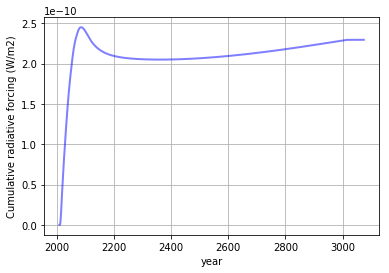

In [17]:
xs, ys  =  timeline.characterize_dynamic("RadiativeForcing",cumulative=True) 

plt.plot(xs, ys, 'b-', lw=2, alpha=0.5)

# Format graph
plt.xlabel("year")
plt.ylabel(r"Cumulative radiative forcing (W/m2)")
plt.grid(True)

plt.legend(loc="lower left")


/home/giuseppec/miniconda3/envs/bw2/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


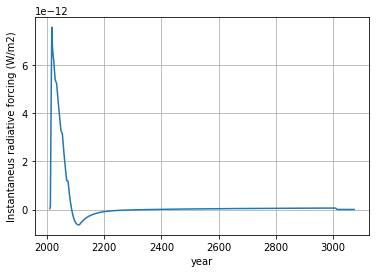

In [18]:
xs, ys  =  timeline.characterize_dynamic("RadiativeForcing",cumulative=False)

plt.plot(xs, ys, linestyle='-')

# Format graph
plt.xlabel("year")
plt.ylabel(r"Instantaneus radiative forcing (W/m2)")
plt.grid(True)

plt.legend(loc="lower left")


In the implemented dynamic CFs for climate (i.e. also in the graphs above) also the impact due to forest regrowth is taken into account. By default it assumes a rotation lenght of 100 years the instantaneous oxidation of wood modelled as a dirac delta function. We can also change the assumed rotation lenght of the forest stands with parameter `rot_stand`, the number of year after harvesting the biogenic carbon is oxidized with `bio_st_emis_yr` and the function  used to model this oxidation with `bio_st_decay` as shown below

/home/giuseppec/miniconda3/envs/bw2/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


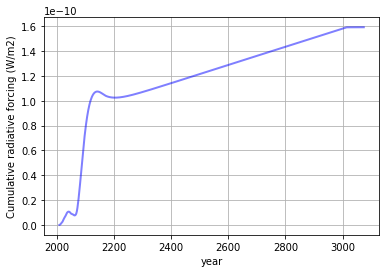

In [19]:
xs, ys  =  timeline.characterize_dynamic("RadiativeForcing",cumulative=True,bio_st_decay='chi2',bio_st_emis_yr=60,rot_stand=150) 

plt.plot(xs, ys, 'b-', lw=2, alpha=0.5)

# Format graph
plt.xlabel("year")
plt.ylabel(r"Cumulative radiative forcing (W/m2)")
plt.grid(True)

plt.legend(loc="lower left")


We can also explore the impact due to each single process both using a static and dynamic characterization factor

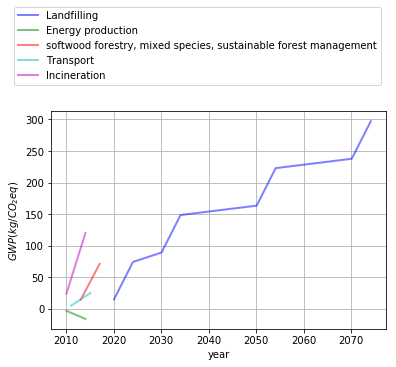

In [20]:
dict_res=timeline.characterize_static_by_process(('IPCC 2013', 'climate change', 'GWP 100a')) #return a dictionary
colors = iter(['b', 'g', 'r', 'c', 'm', 'y', 'k'])

for k,v in dict_res.items():  
    plt.plot(v[0], v[1], 'b-', lw=2, alpha=0.5,label=k,color=next(colors))

# # Format graph
plt.xlabel("year")
plt.ylabel("$GWP (kg/CO_{2}eq)$")
plt.grid(True)

plt.legend(bbox_to_anchor=(1,1.1), loc="lower right")
plt.show()

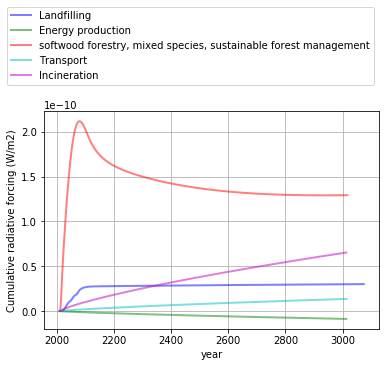

In [21]:
dict_res=timeline.characterize_dynamic_by_process("RadiativeForcing") #return a dictionary
colors = iter(['b', 'g', 'r', 'c', 'm', 'y', 'k'])

for k,v in dict_res.items():  
    plt.plot(v[0], v[1], 'b-', lw=2, alpha=0.5,label=k,color=next(colors))

# # Format graph
plt.xlabel("year")
plt.ylabel(r"Cumulative radiative forcing (W/m2)")
plt.grid(True)

plt.legend(bbox_to_anchor=(1,1.1), loc="lower right")
plt.show()

and each single flow

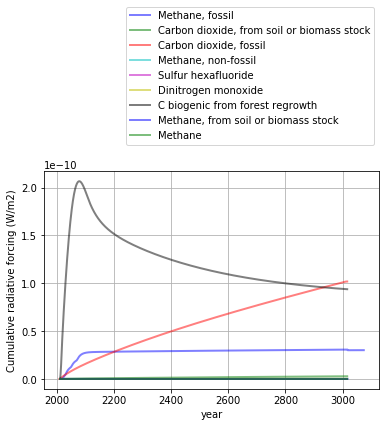

In [22]:
dict_res=timeline.characterize_dynamic_by_flow("RadiativeForcing") #return a dictionary
colors = iter(['b', 'g', 'r', 'c', 'm', 'y', 'k','b', 'g', 'r', 'c', 'm', 'y', 'k'])

for k,v in dict_res.items():  
    plt.plot(v[0], v[1],linestyle= '-', lw=2, alpha=0.5,label=k,color=next(colors))

# # Format graph
plt.xlabel("year")
plt.ylabel(r"Cumulative radiative forcing (W/m2)")
plt.grid(True)

plt.legend(bbox_to_anchor=(1,1.1), loc="lower right")
plt.show()


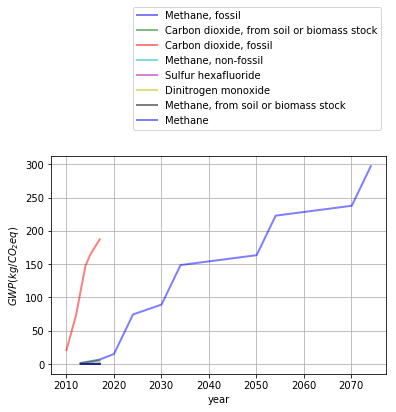

In [32]:
dict_res=timeline.characterize_static_by_flow(('IPCC 2013', 'climate change', 'GWP 100a')) #return a dictionary
colors = iter(['b', 'g', 'r', 'c', 'm', 'y', 'k','b', 'g', 'r', 'c', 'm', 'y', 'k'])
dict_res
for k,v in dict_res.items():  
    plt.plot(v[0], v[1], 'b-', lw=2, alpha=0.5,label=k,color=next(colors))

# # Format graph
plt.xlabel("year")
plt.ylabel("$GWP (kg/CO_{2}eq)$")
plt.grid(True)

plt.legend(bbox_to_anchor=(1,1.1), loc="lower right")
plt.show()

or look just at the impact of one single flow or activity returning their timeline first and characterizing time as in this example

/home/giuseppec/miniconda3/envs/bw2/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


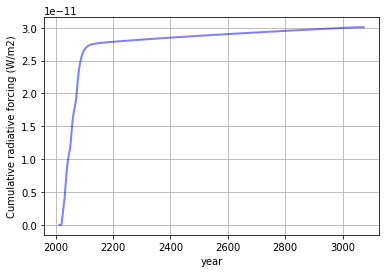

In [31]:
xs, ys=timeline.timeline_for_flow(METHANE).characterize_dynamic("RadiativeForcing")
plt.plot(xs, ys, 'b-', lw=2, alpha=0.5)

# Format graph
plt.xlabel("year")
plt.ylabel(r"Cumulative radiative forcing (W/m2)")
plt.grid(True)

plt.legend(loc="lower left")

/home/giuseppec/miniconda3/envs/bw2/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


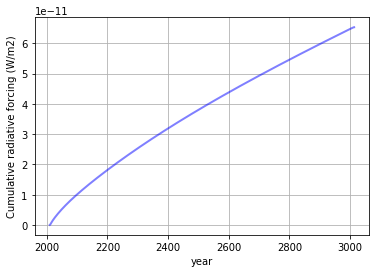

In [33]:
xs, ys=timeline.timeline_for_activity(('example', 'Incineration')).characterize_dynamic("RadiativeForcing")
plt.plot(xs, ys, 'b-', lw=2, alpha=0.5)

# Format graph
plt.xlabel("year")
plt.ylabel(r"Cumulative radiative forcing (W/m2)")
plt.grid(True)

plt.legend(loc="lower left")